# Galaxy zoo image classification - basics with PyTorch

> Marc Huertas-Company & Alexandre Boucaud  
> Ecole Rodolphe Cledassou 2024

In [29]:
# ON COLAB uncomment the line below
!pip install torch torchvision albumentations datasets scikit-learn

  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 3.3 MB/s eta 0:00:00a 0:00:01
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.1
    Uninstalling scipy-1.11.1:
      Successfully uninstalled scipy-1.11.1
ERROR: pip's dependency resolver does not currently take into account all the pa

In [ ]:
!wget https://astdp.net/euclid-zoo-data

In [ ]:
# ON COLAB uncomment the line below
# !unzip /content/euclid-zoo-data -d /content/zoo-data

## Loading and exploring the datasets

The data can be found in https://astdp.net/euclid-zoo-data

Unzip it locally and update the `PATH_TO_DATADIR` according to your system.  
Otherwise use the second method to load directly from the URL.

In [24]:
import torch
import numpy as np
import os, shutil, glob

from datasets import load_dataset,disable_caching

PATH_TO_DATADIR = "zoo-data"

import os, shutil, glob
from datasets import load_dataset

# 1) Remove global caches of imagefolder
hf_home = os.path.expanduser("~/.cache/huggingface/datasets")
for p in glob.glob(os.path.join(hf_home, "imagefolder", "default-*")):
    print("Removing global cache:", p)
    shutil.rmtree(p, ignore_errors=True)

# 2) Remove your project-local cache as well
local_cache = os.path.abspath("./.hf_cache")
print("Removing local cache:", local_cache)
shutil.rmtree(local_cache, ignore_errors=True)
os.makedirs(local_cache, exist_ok=True)

# 3) Rebuild clean
ds = load_dataset(
    "imagefolder",
    data_files={
        "train": ["zoo-data/train/*/*"],
        "test":  ["zoo-data/test/*/*"],
    },
    drop_labels=False,
    keep_in_memory=False,
    cache_dir=local_cache,
    download_mode="force_redownload",   # force a full rebuild
)
train_set, test_set = ds["train"], ds["test"]
print(train_set, test_set)

class_names = train_set.features["label"].names
# Attach a .classes attribute to both splits
for split in ("train", "test"):
    setattr(ds[split], "classes", class_names)


print(train_set.classes)
print(test_set.classes)

Removing local cache: /Users/marchuertascompany/Documents/teaching/EUCLID_school/2025/euclid-school-2025/Y1/notebooks/.hf_cache


Generating train split: 2760 examples [00:00, 28226.01 examples/s]
Generating test split: 691 examples [00:00, 27832.86 examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 2760
}) Dataset({
    features: ['image', 'label'],
    num_rows: 691
})
['featured', 'problem', 'smooth']
['featured', 'problem', 'smooth']


In [7]:
classes = train_set.features['label']

classes

ClassLabel(names=['featured', 'problem', 'smooth'])

In [ ]:
train_set[0]['image'].resize((200, 200))

In [6]:
classes.int2str(train_set[0]['label'])

NameError: name 'classes' is not defined

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
batch_size = 9

# 1) Define transforms (resize to fixed size, to tensor, normalize optional)
IMG_SIZE = 200  # or whatever your model expects
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                           # PIL -> [C,H,W] float in [0,1]
    # transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),  # optional
])

# 2) Collate converts PIL -> tensor (+ labels)
def collate_fn(examples):
    # If images can be grayscale, force RGB for consistent 3 channels:
    imgs = [tfm(ex["image"].convert("RGB")) for ex in examples]
    labels = torch.tensor([ex["label"] for ex in examples], dtype=torch.long)
    return torch.stack(imgs, 0), labels



trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, collate_fn=collate_fn)

globals()["train_loader"] = trainloader
globals()["train_dataset"] = train_set

AttributeError: 'ToTensor' object has no attribute 'astpye'

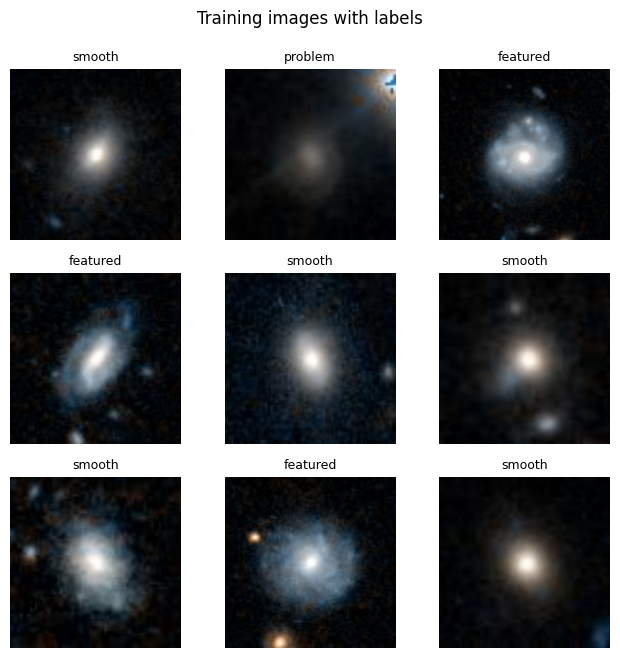

In [27]:
import torch, numpy as np, matplotlib.pyplot as plt


g = globals()

train_loader = g.get('train_loader') or g.get('train_dataloader') or g.get('loader_train') or g.get('train_dl')
train_dataset = g.get('train_set') or g.get('train_ds') or (train_loader.dataset if train_loader is not None and hasattr(train_loader, 'dataset') else None)
assert train_dataset is not None, "Could not locate a training dataset/loader. Please run the data prep cell first."

def label_name(y):
    if hasattr(train_dataset, 'classes'):
        try: return str(train_dataset.classes[int(y)])
        except: return str(y)
    if hasattr(train_dataset, 'class_to_idx'):
        rev = {v:k for k,v in train_dataset.class_to_idx.items()}
        return str(rev.get(int(y), y))
    return str(int(y))

if train_loader is not None:
    images, labels = next(iter(train_loader))
else:
    idx = torch.randperm(len(train_dataset))[:64]
    samples = [train_dataset[i] for i in idx]
    images = torch.stack([s[0] if torch.is_tensor(s[0]) else torchvision.transforms.functional.to_tensor(s[0]) for s in samples])
    labels = torch.tensor([int(s[1]) for s in samples])

B = min(images.shape[0], 64)
R = C = int(np.ceil(np.sqrt(B)))
fig, axes = plt.subplots(R, C, figsize=(2.2*C, 2.2*R))
axes = np.array(axes).reshape(R, C)

def to_display(img):
    x = img.detach().cpu().float()
    if x.ndim == 3 and x.shape[0] in (1,3):
        if x.min() < -0.1 or x.max() > 1.1:
            x = x * 0.5 + 0.5
        x = x.clamp(0,1)
        if x.shape[0] == 1: return x.squeeze(0).numpy(), 'gray'
        else: return np.transpose(x.numpy(), (1,2,0)), None
    return x.numpy(), 'gray'

for i in range(R*C):
    ax = axes[i//C, i% C]
    ax.axis('off')
    if i >= B: continue
    img, cmap = to_display(images[i])
    ax.imshow(img, cmap=cmap)
    ax.set_title(label_name(labels[i]), fontsize=9)

plt.suptitle("Training images with labels", y=0.99)
plt.tight_layout(); plt.show()

## Defining data augmentations

This will use the transformations defined in https://albumentations.ai/docs/ to augment the datasets

In [30]:
import albumentations as A

data_augmentation_pipeline = A.Compose([
    A.Rotate(limit=180, interpolation=1,
                always_apply=True, border_mode=0, value=0),
    A.RandomResizedCrop(
        height=224,  # after crop resize
        width=224,
        scale=(0.7, 0.8),  # crop factor
        ratio=(0.9, 1.1),  # crop aspect ratio
        interpolation=1,  # This is "INTER_LINEAR" == BILINEAR interpolation. See: https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
        always_apply=True
    ),  # new aspect ratio
    A.VerticalFlip(p=0.5),
    A.ToFloat(max_value=255.0, always_apply=True),
])    

def augment_func(samples):
    samples["pixel_values"] = [
        data_augmentation_pipeline(image=np.array(image))["image"] for image in samples["image"]
    ]
    return samples

train_set.set_transform(augment_func)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/numpy/_typing/_scalars.py:12: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  _BoolLike_co: TypeAlias = bool | np.bool


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

However we don't want these augmentations to be applied to the test images. We only want to standardize them.

In [ ]:

standardization_pipeline = A.Compose([
    A.Resize(height=224, width=224, interpolation=1), 
    A.ToFloat(max_value=255.0, always_apply=True),
])

def standardize_func(samples):
    samples["pixel_values"] = [
        standardization_pipeline(image=np.array(image))["image"] for image in samples["image"]
    ]
    return samples

test_set.set_transform(standardize_func)

## Creating a convolutional network to extract features from the images from scratch

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 4)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


net = Net()

The loss function for this classification problem will be a cross entropy loss.

We also set up the optimizer for the training phase.

In [ ]:
import torch.optim as optim

LEARNING_RATE = 1e-4

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9)

Before we start training, we can create a dataloader that will take the sample images from the dataset by batch of `batch_size`, apply the data augmentation and feed them to the neural network following a scheme defined in the `collate_fn` function below.

In [ ]:
batch_size = 8

def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"]) for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return  pixel_values.permute(0, 3, 1, 2), labels

trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                          shuffle=True, collate_fn=collate_fn)

testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, collate_fn=collate_fn)

## Training

This is the training script that will run for a number of epochs

In [ ]:
N_EPOCHS = 3

for epoch in range(N_EPOCHS):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 30 == 0:
            print(f'Epoch {epoch + 1:2d}, batch {i + 1:3d}] | loss: {running_loss / 30:.3f}')
            running_loss = 0.0

print('Finished Training')

After training we can save the model state into a file so we can load it back again later.

In [ ]:
torch.save(net.state_dict(), 'convnet.pth')

In [ ]:
net = Net()
net.load_state_dict(torch.load('convnet.pth'))

## Model evaluation

Finally we can evaluate the network on the test data

In [ ]:
correct = 0
total = 0
y_true = np.array([])
y_pred = np.array([])
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true = np.concatenate([y_true, np.array(labels)])
        y_pred = np.concatenate([y_pred, np.array(predicted)])

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes.names)
disp.plot()

## Exercices

You job, if you accept it, is to improve the accuracy of the model.

To do so, here are some ideas:
- try new data augmentations from the Albumentations package (https://albumentations.ai/docs/)
- explore new CNN architectures found on the web (GitHub, Kaggle, arXiv..)
- look at the effect of the learning rate, epochs and batch_size on the training loss

## 🔍 Visualize a grid of training images (labels shown)

This cell grabs a batch from the training loader, plots a grid, and overlays the **class name / id**.
If your dataset was normalized, the code tries to roughly **de-normalize** for display.

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt

g = globals()
train_loader = g.get('train_loader') or g.get('train_dataloader') or g.get('loader_train') or g.get('train_dl')
train_dataset = g.get('train_dataset') or g.get('train_ds') or (train_loader.dataset if train_loader is not None and hasattr(train_loader, 'dataset') else None)
assert train_dataset is not None, "Could not locate a training dataset/loader. Please run the data prep cell first."

def label_name(y):
    if hasattr(train_dataset, 'classes'):
        try: return str(train_dataset.classes[int(y)])
        except: return str(y)
    if hasattr(train_dataset, 'class_to_idx'):
        rev = {v:k for k,v in train_dataset.class_to_idx.items()}
        return str(rev.get(int(y), y))
    return str(int(y))

if train_loader is not None:
    images, labels = next(iter(train_loader))
else:
    idx = torch.randperm(len(train_dataset))[:64]
    samples = [train_dataset[i] for i in idx]
    images = torch.stack([s[0] if torch.is_tensor(s[0]) else torchvision.transforms.functional.to_tensor(s[0]) for s in samples])
    labels = torch.tensor([int(s[1]) for s in samples])

B = min(images.shape[0], 64)
R = C = int(np.ceil(np.sqrt(B)))
fig, axes = plt.subplots(R, C, figsize=(2.2*C, 2.2*R))
axes = np.array(axes).reshape(R, C)

def to_display(img):
    x = img.detach().cpu().float()
    if x.ndim == 3 and x.shape[0] in (1,3):
        if x.min() < -0.1 or x.max() > 1.1:
            x = x * 0.5 + 0.5
        x = x.clamp(0,1)
        if x.shape[0] == 1: return x.squeeze(0).numpy(), 'gray'
        else: return np.transpose(x.numpy(), (1,2,0)), None
    return x.numpy(), 'gray'

for i in range(R*C):
    ax = axes[i//C, i% C]
    ax.axis('off')
    if i >= B: continue
    img, cmap = to_display(images[i])
    ax.imshow(img, cmap=cmap)
    ax.set_title(label_name(labels[i]), fontsize=9)

plt.suptitle("Training images with labels", y=0.99)
plt.tight_layout(); plt.show()

## 🧠 Train a tiny ViT **from scratch** (analogous to the CNN)

This defines a small ViT and trains it using the same data loaders. It uses sinusoidal 2D positional
embeddings so it works with arbitrary image sizes (no fixed 224×224 assumption).

In [ ]:
import math, time, torch, torch.nn as nn, torch.nn.functional as F
import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

g = globals()
train_loader = g.get('train_loader') or g.get('train_dataloader') or g.get('loader_train') or g.get('train_dl')
val_loader   = g.get('val_loader') or g.get('valid_loader') or g.get('loader_val') or g.get('loader_valid')
train_dataset = g.get('train_dataset') or (train_loader.dataset if train_loader is not None else None)

assert train_loader is not None, "Need a training DataLoader named train_loader (or similar)."

def infer_num_classes(ds):
    if hasattr(ds, 'classes'): return len(ds.classes)
    if hasattr(ds, 'class_to_idx'): return len(ds.class_to_idx)
    X,Y = next(iter(train_loader))
    return int(max(Y).item()) + 1

num_classes = g.get('num_classes') or (infer_num_classes(train_dataset) if train_dataset is not None else infer_num_classes(None))
epochs_vit  = g.get('epochs') or 10
lr_vit      = 3e-4

class PatchEmbed(nn.Module):
    def __init__(self, in_ch=3, embed_dim=192, patch=8):
        super().__init__()
        self.patch = patch
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch, stride=patch)
    def forward(self, x):
        x = self.proj(x)
        B, D, H, W = x.shape
        x = x.flatten(2).transpose(1,2)
        return x, (H, W)

def sinusoidal_2d(h, w, dim):
    y, x = torch.meshgrid(torch.arange(h), torch.arange(w), indexing='ij')
    y = y.flatten().float(); x = x.flatten().float()
    assert dim % 4 == 0, "dim must be multiple of 4"
    dim_half = dim // 4
    wy = 1.0 / (10000 ** (torch.arange(dim_half).float() / dim_half))
    wx = 1.0 / (10000 ** (torch.arange(dim_half).float() / dim_half))
    out = []
    for i in range(dim_half):
        out += [torch.sin(y * wy[i]), torch.cos(y * wy[i])]
    for i in range(dim_half):
        out += [torch.sin(x * wx[i]), torch.cos(x * wx[i])]
    pe = torch.stack(out, dim=1)
    return pe

class MLP(nn.Module):
    def __init__(self, dim, hidden_mult=4, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim*hidden_mult)
        self.fc2 = nn.Linear(dim*hidden_mult, dim)
        self.act = nn.GELU()
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x); x = self.act(x); x = self.drop(x)
        x = self.fc2(x); x = self.drop(x); return x

class Block(nn.Module):
    def __init__(self, dim, heads=3, drop=0.0, mlp_mult=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn  = nn.MultiheadAttention(dim, num_heads=heads, batch_first=True, dropout=drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp   = MLP(dim, mlp_mult, drop)
    def forward(self, x):
        h = x; x = self.norm1(x)
        x, _ = self.attn(x, x, x, need_weights=False); x = x + h
        h = x; x = self.norm2(x)
        x = self.mlp(x); x = x + h
        return x

class TinyViT(nn.Module):
    def __init__(self, in_ch=3, num_classes=10, embed_dim=128, depth=6, heads=4, patch=8, drop=0.0):
        super().__init__()
        self.embed = PatchEmbed(in_ch, embed_dim, patch)
        self.cls_token = nn.Parameter(torch.zeros(1,1,embed_dim))
        self.pos_drop = nn.Dropout(drop)
        self.blocks = nn.ModuleList([Block(embed_dim, heads, drop) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
    def forward(self, x):
        B, C, H, W = x.shape
        x, (h, w) = self.embed(x)
        pe = sinusoidal_2d(h, w, x.shape[-1]).to(x.device)
        pe = pe.unsqueeze(0).expand(B, -1, -1)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        pe_cls = torch.zeros(B, 1, x.shape[-1], device=x.device)
        x = x + torch.cat([pe_cls, pe], dim=1)
        x = self.pos_drop(x)
        for blk in self.blocks: x = blk(x)
        x = self.norm(x)[:,0]
        return self.head(x)

try:
    sample_x, _ = next(iter(train_loader))
    in_ch = sample_x.shape[1]
except:
    in_ch = 3

vit_model = TinyViT(in_ch=in_ch, num_classes=num_classes, embed_dim=128, depth=6, heads=4, patch=8, drop=0.0).to(device)
opt = torch.optim.AdamW(vit_model.parameters(), lr=lr_vit, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader):
    model.train(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        opt.zero_grad(); loss.backward(); opt.step()
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

@torch.no_grad()
def eval_accuracy(model, loader):
    model.eval(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

print(f"Training TinyViT from scratch for {epochs_vit} epochs on device: {device}")
vit_history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
for ep in range(1, epochs_vit+1):
    tr_loss, tr_acc = train_one_epoch(vit_model, train_loader)
    if val_loader is not None:
        va_loss, va_acc = eval_accuracy(vit_model, val_loader)
    else:
        va_loss, va_acc = float('nan'), float('nan')
    vit_history["train_loss"].append(tr_loss); vit_history["train_acc"].append(tr_acc)
    vit_history["val_loss"].append(va_loss);   vit_history["val_acc"].append(va_acc)
    print(f"[ViT][{ep:03d}/{epochs_vit}] train loss={tr_loss:.4f} acc={tr_acc:.4f} | val loss={va_loss:.4f} acc={va_acc:.4f}")

## 📊 Compare CNN vs ViT results

This cell looks for a CNN model defined earlier (e.g., `cnn_model` or `model`) and compares its validation accuracy to the newly trained `vit_model`.

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cnn_model = globals().get('cnn_model')
if cnn_model is None:
    m = globals().get('model')
    if isinstance(m, torch.nn.Module) and m is not globals().get('vit_model'):
        cnn_model = m

assert vit_model is not None, "No vit_model found. Please run the ViT cell first."

val_loader = globals().get('val_loader') or globals().get('valid_loader') or globals().get('loader_val') or globals().get('loader_valid') or globals().get('train_loader')
assert val_loader is not None, "Need a validation (or training) DataLoader to compare."

@torch.no_grad()
def accuracy(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval(); total=correct=0; loss_sum=0.0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        logits = model(X); loss = criterion(logits,y)
        loss_sum += loss.item()*X.size(0)
        pred = logits.argmax(1); total += y.size(0); correct += (pred==y).sum().item()
    return loss_sum/total, correct/total

vit_val_loss, vit_val_acc = accuracy(vit_model, val_loader)
if cnn_model is not None:
    cnn_val_loss, cnn_val_acc = accuracy(cnn_model, val_loader)
else:
    cnn_val_loss, cnn_val_acc = float('nan'), float('nan')

print("Validation comparison:")
print(f"  CNN: loss={cnn_val_loss:.4f}, acc={cnn_val_acc:.4f}")
print(f"  ViT: loss={vit_val_loss:.4f}, acc={vit_val_acc:.4f}")